# Week 5-Causal Diagram



---
**Outline**

1. Review
2. Session 1: Matching
   - Estimating Job Training on Earnings
   - Drug Effect on Recovery
   - Brookman Study
3. Session 2: Fixed Effect
   - GDP on Life Expectancy
     - Fixed Effect
     - Two Way Fixed Effect

---
## Matching

- Matching intuition: constructing comparison groups to close back doors.
- Usually applied to binary treated/untreated variables.
- Goal of matching: Make treatment and control groups comparable.
- Matching methods assign weights to observations to achieve comparability.
- To assess the effect of a treatment, compute a weighted average of the results observed in both the treatment and control groups. By comparing these averages, we can estimate the effect of the treatment.
---
### Distance Macthing

- Observations are considered similar if they have similar values of the matching variables.
- The goal is to minimize the distance between treatment and control observations, in term of how far their covariate values.
- By reducing variation in matching variables, distance matching helps address potential back doors.

---
### Propensity Score Matching
- Propensity score is the probability that someone will be treated.
- Propensity score matching considers observations similar if they had an equal likelihood of being treated, meaning they have equal treatment propensity.
- Idea: Try to predict an observation propensity for being treated based on the matching variables. Then figure out what’s best kind of matches are in term of how likely they are to be treated


In [3]:
!pip install linearmodels
!pip install causalinference


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.0 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import linearmodels as lm
from causalinference.causal import CausalModel

# Estimating Job Training on Earnings
---

In [5]:
trainee = pd.read_csv("trainees.csv")
trainee.head()

,unit,trainees,age,earnings
0,1,1,28,17700
1,2,1,34,10200
2,3,1,29,14400
3,4,1,25,20800
4,5,1,29,6100


In [6]:
trainee.groupby("trainees")["age"].mean()

,age
trainees,
0,33.000000
1,28.473684


In [7]:
trainee.groupby("trainees")["earnings"].mean()

,earnings
trainees,
0,20723.809524
1,16426.315789


In [8]:
# get people who get training

condition_training = (trainee["trainees"] == 1)

training_group = trainee[condition_training].copy()
training_group.head()

,unit,trainees,age,earnings
0,1,1,28,17700
1,2,1,34,10200
2,3,1,29,14400
3,4,1,25,20800
4,5,1,29,6100


In [9]:
# get people who did not get training

condition_not_training = (trainee["trainees"] == 0)

non_training_group = trainee[condition_not_training].copy()
non_training_group.head()

,unit,trainees,age,earnings
19,20,0,43,20900
20,21,0,50,31000
21,22,0,30,21000
22,23,0,27,9300
23,24,0,54,41100


In [10]:
# Calculate the difference of earning from those who do training and not

earning_training = training_group["earnings"].mean()
earning_not_training = non_training_group["earnings"].mean()

att = earning_training - earning_not_training
att

np.float64(-4297.49373433584)

## Matching

- Let's do matching to control age
- We want to look for the comparable group of people in treated group from the control group with respect to their age
- By doing so, we control the age

In [11]:
training_group.head()

,unit,trainees,age,earnings
0,1,1,28,17700
1,2,1,34,10200
2,3,1,29,14400
3,4,1,25,20800
4,5,1,29,6100


In [12]:
non_training_group[non_training_group["age"]==28]

,unit,trainees,age,earnings
26,27,0,28,8800


In [13]:
non_training_group[non_training_group["age"]==34]

,unit,trainees,age,earnings
32,34,0,34,24200


In [14]:
non_training_group[non_training_group["age"]==29]

,unit,trainees,age,earnings
35,37,0,29,6200


In [15]:
# Dataset where no one has the same age from treated group
unique_on_age = non_training_group.drop_duplicates("age")
unique_on_age.head()

,unit,trainees,age,earnings
19,20,0,43,20900
20,21,0,50,31000
21,22,0,30,21000
22,23,0,27,9300
23,24,0,54,41100


In [16]:
# Pair each on treated group with untreated group with age as match variable
matches = training_group.merge(unique_on_age, on="age", how="left", suffixes=("_t_1", "_t_0"))
matches.head()

,unit_t_1,trainees_t_1,age,earnings_t_1,unit_t_0,trainees_t_0,earnings_t_0
0,1,1,28,17700,27,0,8800
1,2,1,34,10200,34,0,24200
2,3,1,29,14400,37,0,6200
3,4,1,25,20800,35,0,23300
4,5,1,29,6100,37,0,6200


In [17]:
# create column as difference of earning from bot group
matches["t1_minuts_t0"] = matches["earnings_t_1"] - matches["earnings_t_0"]
matches.head(7)

,unit_t_1,trainees_t_1,age,earnings_t_1,unit_t_0,trainees_t_0,earnings_t_0,t1_minuts_t0
0,1,1,28,17700,27,0,8800,8900
1,2,1,34,10200,34,0,24200,-14000
2,3,1,29,14400,37,0,6200,8200
3,4,1,25,20800,35,0,23300,-2500
4,5,1,29,6100,37,0,6200,-100
5,6,1,23,28600,40,0,9500,19100
6,7,1,33,21900,29,0,15500,6400


In [18]:
matches["t1_minuts_t0"].mean()

np.float64(2457.8947368421054)

- However, the previous example was intentionally designed to illustrate the concept of matching.
- In real-world scenarios, the situation is more complex, as we typically deal with multiple variables, and units may not have perfect matches.
- In such cases, we need to establish a measure of proximity or similarity to determine how closely units resemble each other. This measurement helps us compare and identify suitable matches, even when perfect matches are not feasible.

One common metric for this is the euclidean distance

$$||X_i - X_j||$$

Once we have established the distance measure, we can define the match as the nearest neighbor to the sample we want to match. In other words, we identify the unit in the control group that is closest to the treated unit in terms of the defined distance measure.

# Impact of a Drug on Recovery

In [19]:
med = pd.read_csv("medicine_impact_recovery.csv")
med.head()

,sex,age,severity,medication,recovery
0,0,35.049134,0.887658,1,31
1,1,41.580323,0.899784,1,49
2,1,28.127491,0.486349,0,38
3,1,36.375033,0.323091,0,35
4,0,25.091717,0.209006,0,15


In [20]:
treated_group = med[med["medication"]==1]
untreated_group = med[med["medication"]==0]

treated_group["recovery"].mean() - untreated_group["recovery"].mean()

np.float64(16.895799546498726)

In [22]:
def fit_standardize(data):
    data_mean = data.mean()
    data_std = data.std()
    return (data_mean, data_std)

def transform_standardize(data):
    mean, std = fit_standardize(data)
    transformed_data = (data - mean)/std
    return transformed_data

# standardization

X = ["severity", "age", "sex"]
y = "recovery"

med["sex_std"] = transform_standardize(med["sex"])
med["age_std"] = transform_standardize(med["age"])
med["severity_std"] = transform_standardize(med["severity"])

treated_group = med[med["medication"]==1]
untreated_group = med[med["medication"]==0]

In [23]:
treated_group

,sex,age,severity,medication,recovery,sex_std,age_std,severity_std
0,0,35.049134,0.887658,1,31,-0.996980,0.280787,1.459800
1,1,41.580323,0.899784,1,49,1.002979,0.865375,1.502164
7,0,48.616165,0.832912,1,38,-0.996980,1.495134,1.268540
10,1,30.721868,0.626067,1,34,1.002979,-0.106534,0.545911
16,0,32.392880,0.878765,1,30,-0.996980,0.043034,1.428732
...,...,...,...,...,...,...,...,...
19982,1,36.874275,0.947188,1,48,1.002979,0.444150,1.667773
19988,1,23.681364,0.534920,1,28,1.002979,-0.736709,0.227483
19989,1,43.113317,0.563223,1,39,1.002979,1.002589,0.326361
19993,1,50.098852,0.733380,1,49,1.002979,1.627845,0.920818


In [24]:
from sklearn.neighbors import KNeighborsRegressor

In [25]:
model = KNeighborsRegressor(n_neighbors=1)

X = ["sex_std","age_std","severity_std"]
y = ["recovery"]

mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated_group[X], untreated_group[y])

In [26]:
mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated_group[X], treated_group[y])

In [27]:
# find matches for the treated looking at the untreated knn model
treated_group["match"] = mt0.predict(treated_group[X])
treated_group

/tmp/ipython-input-27-3297836690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_group["match"] = mt0.predict(treated_group[X])


,sex,age,severity,medication,recovery,sex_std,age_std,severity_std,match
0,0,35.049134,0.887658,1,31,-0.996980,0.280787,1.459800,39.0
1,1,41.580323,0.899784,1,49,1.002979,0.865375,1.502164,52.0
7,0,48.616165,0.832912,1,38,-0.996980,1.495134,1.268540,46.0
10,1,30.721868,0.626067,1,34,1.002979,-0.106534,0.545911,45.0
16,0,32.392880,0.878765,1,30,-0.996980,0.043034,1.428732,39.0
...,...,...,...,...,...,...,...,...,...
19982,1,36.874275,0.947188,1,48,1.002979,0.444150,1.667773,48.0
19988,1,23.681364,0.534920,1,28,1.002979,-0.736709,0.227483,38.0
19989,1,43.113317,0.563223,1,39,1.002979,1.002589,0.326361,49.0
19993,1,50.098852,0.733380,1,49,1.002979,1.627845,0.920818,56.0


In [28]:
X = ["sex_std","age_std","severity_std"]

# find matches for the untreated looking at the treated knn model
untreated_group["match"] = mt1.predict(untreated_group[X])
untreated_group

/tmp/ipython-input-28-3560259174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  untreated_group["match"] = mt1.predict(untreated_group[X])


,sex,age,severity,medication,recovery,sex_std,age_std,severity_std,match
2,1,28.127491,0.486349,0,38,1.002979,-0.338749,0.057796,28.0
3,1,36.375033,0.323091,0,35,1.002979,0.399465,-0.512557,28.0
4,0,25.091717,0.209006,0,15,-0.996980,-0.610473,-0.911125,20.0
5,0,23.224040,0.202580,0,14,-0.996980,-0.777643,-0.933575,20.0
6,0,17.653188,0.205155,0,12,-0.996980,-1.276274,-0.924577,18.0
...,...,...,...,...,...,...,...,...,...
19994,1,55.341886,0.380557,0,48,1.002979,2.097134,-0.311796,44.0
19996,1,14.383792,0.072034,0,5,1.002979,-1.568909,-1.389646,21.0
19997,0,47.987401,0.431465,0,37,-0.996980,1.438855,-0.133945,31.0
19998,0,27.824466,0.082126,0,6,-0.996980,-0.365872,-1.354389,20.0


In [29]:
predicted = pd.concat([
    # find matches for the treated looking at the untreated knn model
    treated_group.assign(match=mt0.predict(treated_group[X])),

    # find matches for the untreated looking at the treated knn model
    untreated_group.assign(match=mt1.predict(untreated_group[X]))
])

In [30]:
predicted = pd.concat([
    # find matches for the treated looking at the untreated knn model
    treated_group.assign(match=mt0.predict(treated_group[X])),

    # find matches for the untreated looking at the treated knn model
    untreated_group.assign(match=mt1.predict(untreated_group[X]))
])

In [31]:
def fit_standardize(data):
    data_mean = data.mean()
    data_std = data.std()
    return (data_mean, data_std)

def transform_standardize(data):
    mean, std = fit_standardize(data)
    transformed_data = (data - mean)/std
    return transformed_data

# standardization

X = ["severity", "age", "sex"]
y = "recovery"

med["sex_std"] = transform_standardize(med["sex"])
med["age_std"] = transform_standardize(med["age"])
med["severity_std"] = transform_standardize(med["severity"])

treated_group = med[med["medication"]==1]
untreated_group = med[med["medication"]==0]

In [ ]:
treated_group

In [32]:
from sklearn.neighbors import KNeighborsRegressor

In [33]:
model = KNeighborsRegressor(n_neighbors=1)

X = ["sex_std","age_std","severity_std"]
y = ["recovery"]

mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated_group[X], untreated_group[y])

In [34]:
mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated_group[X], treated_group[y])

In [35]:
# find matches for the treated looking at the untreated knn model
treated_group["match"] = mt0.predict(treated_group[X])
treated_group

/tmp/ipython-input-35-3297836690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_group["match"] = mt0.predict(treated_group[X])


,sex,age,severity,medication,recovery,sex_std,age_std,severity_std,match
0,0,35.049134,0.887658,1,31,-0.996980,0.280787,1.459800,39.0
1,1,41.580323,0.899784,1,49,1.002979,0.865375,1.502164,52.0
7,0,48.616165,0.832912,1,38,-0.996980,1.495134,1.268540,46.0
10,1,30.721868,0.626067,1,34,1.002979,-0.106534,0.545911,45.0
16,0,32.392880,0.878765,1,30,-0.996980,0.043034,1.428732,39.0
...,...,...,...,...,...,...,...,...,...
19982,1,36.874275,0.947188,1,48,1.002979,0.444150,1.667773,48.0
19988,1,23.681364,0.534920,1,28,1.002979,-0.736709,0.227483,38.0
19989,1,43.113317,0.563223,1,39,1.002979,1.002589,0.326361,49.0
19993,1,50.098852,0.733380,1,49,1.002979,1.627845,0.920818,56.0


In [36]:
X = ["sex_std","age_std","severity_std"]

# find matches for the untreated looking at the treated knn model
untreated_group["match"] = mt1.predict(untreated_group[X])
untreated_group

/tmp/ipython-input-36-3560259174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  untreated_group["match"] = mt1.predict(untreated_group[X])


,sex,age,severity,medication,recovery,sex_std,age_std,severity_std,match
2,1,28.127491,0.486349,0,38,1.002979,-0.338749,0.057796,28.0
3,1,36.375033,0.323091,0,35,1.002979,0.399465,-0.512557,28.0
4,0,25.091717,0.209006,0,15,-0.996980,-0.610473,-0.911125,20.0
5,0,23.224040,0.202580,0,14,-0.996980,-0.777643,-0.933575,20.0
6,0,17.653188,0.205155,0,12,-0.996980,-1.276274,-0.924577,18.0
...,...,...,...,...,...,...,...,...,...
19994,1,55.341886,0.380557,0,48,1.002979,2.097134,-0.311796,44.0
19996,1,14.383792,0.072034,0,5,1.002979,-1.568909,-1.389646,21.0
19997,0,47.987401,0.431465,0,37,-0.996980,1.438855,-0.133945,31.0
19998,0,27.824466,0.082126,0,6,-0.996980,-0.365872,-1.354389,20.0


In [37]:
predicted = pd.concat([
    # find matches for the treated looking at the untreated knn model
    treated_group.assign(match=mt0.predict(treated_group[X])),

    # find matches for the untreated looking at the treated knn model
    untreated_group.assign(match=mt1.predict(untreated_group[X]))
])

In [38]:
medication = 2*predicted["medication"] - 1
medication

,medication
0,1
1,1
7,1
10,1
16,1
...,...
19994,-1
19996,-1
19997,-1
19998,-1


In [39]:
y_yjm = predicted["recovery"] - predicted["match"]
y_yjm

,0
0,-8.0
1,-3.0
7,-8.0
10,-11.0
16,-9.0
...,...
19994,4.0
19996,-16.0
19997,6.0
19998,-14.0


In [40]:
np.mean(medication*y_yjm)

np.float64(-0.9954)

In [41]:
from causalinference import CausalModel

cm = CausalModel(Y=med["recovery"].values,
                 D=med["medication"].values,
                 X=med[["severity", "age", "sex"]].values
)

cm.est_via_matching(matches=1)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.995      1.187     -0.838      0.402     -3.323      1.332
           ATC      2.482      0.918      2.703      0.007      0.682      4.282
           ATT     -7.563      2.950     -2.564      0.010    -13.344     -1.781



# Broockman Study
---

**Background**
- In this research, Broockman aims to explore the inherent motivations driving American politicians. Specifically, he investigates the actions they take even when there is no apparent immediate benefit. He examines the possibility that Black politicians in America may be particularly tend to support the Black American community as an intrinsic motivation.
- To conduct the experiment, in 2010, he sent a series of emails to state legislators, requesting information on unemployment benefits. Each email was sent under the fictional name "Tyrone Washington," a name that strongly suggests it belongs to a Black man, to explore potential racial implications.
- To examine intrinsic motivation, Broockman analyzes whether legislators respond to in-district and out-of-district emails differently.
- Responding to out-of-district emails may not offer direct benefits to the legislator, as those constituents cannot vote for them. However, a positive response might indicate a sense of duty or kindness.

In [43]:
!pip install causaldata


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for causaldata: filename=causaldata-0.1.5-py3-none-any.whl size=2767646 sha256=932849694fe2547bdc61272393a613b41ac360af691bf5f52c82c5cc9e215359
  Stored in directory: /root/.cache/pip/wheels/a1/03/f7/4feb3ae1964932dc58fe5acfc4bdb02d5df05dd6b8aa2d8437
Successfully built causaldata


In [44]:
from causaldata import black_politicians
br = black_politicians.load_pandas().data
br.head()

,leg_black,treat_out,responded,totalpop,medianhhincom,black_medianhh,white_medianhh,blackpercent,statessquireindex,nonblacknonwhite,urbanpercent,leg_senator,leg_democrat,south
0,0,0,0,1.5873,5.0625,2.6814,2.6586,0.007119,0.227,0,0.695601,0,0,0
1,0,0,1,1.6218,4.9713,2.7126,2.6619,0.005796,0.227,0,0.618073,0,0,0
2,0,0,1,1.6710,6.9646,2.3087,2.9973,0.012029,0.227,0,0.824331,0,0,0
3,0,0,1,1.6122,4.1811,2.4668,2.4887,0.004280,0.227,1,0.000000,0,0,0
4,0,1,1,1.5622,3.1152,2.1490,2.0597,0.008258,0.227,1,0.000000,0,1,0


**Finding**
- The study reveals that both Black and non-Black legislators respond less to out-of-district emails from Black senders than in-district emails.
- However, the key finding is that the in-district/out-of-district difference is smaller for Black legislators compared to non-Black ones. This suggests that Black legislators exhibit additional intrinsic motivation to assist Black constituents.
- Matching techniques come into play when comparing the in-district/out-of-district gaps between Black and non-Black legislators.

In [45]:
br.groupby(["leg_black"])[["responded"]].sum()

,responded
leg_black,
0,2222
1,143



- Since these groups are elected in different kinds of places with varying factors, matching helps create a more reliable comparison group.
- In the original study, Broockman used matching variables such as
  - median household income in the district,
  - the percentage of the district's Black population, and
  - whether the legislator is a Democrat.
  
- This approach enhances the validity of the findings and supports the intrinsic-motivation hypothesis and the legislators-help-those-like-themselves hypothesis.

Although the actual study design is more complex, we will focus on the relationship between leg_black and responded after matching on medianhhincom, blackpercent, and leg_democrat. Further details about the comprehensive analysis will be addressed later.

-  this analysis, we will be using one-to-one nearest neighbor matching with a Mahalanobis distance measure, incorporating three matching variables (medianhhincom, blackpercent, leg_democrat).
- Our aim is to match districts with Black legislators to those without (leg_black) to explore the impact of this factor on the outcome variable responded, which represents whether the legislator responded to the email.

### Process

- The code comprises two main parts: first, the calculation of matching weights, and second, the estimation of the treatment effect on the outcome variable.

- For now, let's examine the impact of leg_black on the response rate after the Mahalanobis matching procedure.

In [46]:
# outcome
Y = br['responded'].to_numpy()

# treatment
D = br['leg_black'].to_numpy()

# matching variables
X = br[['medianhhincom', 'blackpercent', 'leg_democrat']].to_numpy()
X

array([[5.0625000e+00, 7.1190070e-03, 0.0000000e+00],
       [4.9713000e+00, 5.7960290e-03, 0.0000000e+00],
       [6.9646000e+00, 1.2028725e-02, 0.0000000e+00],
       ...,
       [3.1691000e+00, 2.3394550e-03, 0.0000000e+00],
       [3.1230000e+00, 4.7619050e-03, 1.0000000e+00],
       [5.2692000e+00, 2.7681660e-03, 1.0000000e+00]])

In [47]:
# Set up our model
M = CausalModel(Y, D, X)

# Fit, using Mahalanobis distance
M.est_via_matching(weights = 'maha', matches = 1)

print(M.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.050      0.175     -0.285      0.776     -0.392      0.293
           ATC     -0.052      0.186     -0.282      0.778     -0.418      0.313
           ATT     -0.012      0.099     -0.120      0.904     -0.206      0.182



### Propensity Score Weighting

**Propensity Score Estimation Using Regression:**
- Propensity scores are typically estimated using logit or probit regression.
- Constructing the regression model tak into considerations include including determinants of treatment as predictors.
- Functional form concerns like using polynomials or interactions for matching variables must also be addressed.
- Maintaining a causal diagram mindset is crucial to closing back doors and excluding front-door predictors.

In [48]:
Y = br['responded'].to_numpy()
D = br['leg_black'].to_numpy()
X = br[['medianhhincom', 'blackpercent', 'leg_democrat']].to_numpy()

In [49]:
# Set up our model
M = CausalModel(Y, D, X)
M

In [50]:
# Estimate the propensity score using logit
M.est_propensity()

In [51]:
# Trim the score with improved algorithm trim_s to improve balance
M.trim_s()

In [52]:
# If we want to use the scores elsewhere, export them (we could have also done this with sm.Logit)
br['ps'] = M.propensity['fitted']
br[['medianhhincom', 'blackpercent', 'leg_democrat','responded','ps']]

,medianhhincom,blackpercent,leg_democrat,responded,ps
0,5.0625,0.007119,0,0,0.001180
1,4.9713,0.005796,0,1,0.001171
2,6.9646,0.012029,0,1,0.001087
3,4.1811,0.004280,0,1,0.001219
4,3.1152,0.008258,1,1,0.009673
...,...,...,...,...,...
5588,5.1551,0.001155,0,1,0.001101
5589,3.6007,0.001816,0,1,0.001237
5590,3.1691,0.002339,0,1,0.001282
5591,3.1230,0.004762,1,1,0.009320


In [53]:
M.est_via_weighting()

print(M.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.047      0.080      0.588      0.557     -0.109      0.203



In [54]:
# Or we can do our own weighting

br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1-br['ps']))
br[['medianhhincom', 'blackpercent', 'leg_democrat','responded','ps','ipw']]

,medianhhincom,blackpercent,leg_democrat,responded,ps,ipw
0,5.0625,0.007119,0,0,0.001180,1.001181
1,4.9713,0.005796,0,1,0.001171,1.001173
2,6.9646,0.012029,0,1,0.001087,1.001088
3,4.1811,0.004280,0,1,0.001219,1.001220
4,3.1152,0.008258,1,1,0.009673,1.009768
...,...,...,...,...,...,...
5588,5.1551,0.001155,0,1,0.001101,1.001102
5589,3.6007,0.001816,0,1,0.001237,1.001239
5590,3.1691,0.002339,0,1,0.001282,1.001284
5591,3.1230,0.004762,1,1,0.009320,1.009408


In [55]:
m = sm.wls(formula = 'responded ~ leg_black', weights = br['ipw'], data = br).fit()

m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              responded   R-squared:                       0.022
Model:                            WLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     128.6
Date:                Fri, 18 Jul 2025   Prob (F-statistic):           1.75e-29
Time:                        22:47:46   Log-Likelihood:                -5768.6
No. Observations:                5593   AIC:                         1.154e+04
Df Residuals:                    5591   BIC:                         1.155e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4100      0.009     43.596      0.000       0.392       0.428
leg_black      0.1499      0.013     11.340      0.000       0.124       0.176
==============================================================================
Omnibus:                     2184.371   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2062976.257
Skew:                           0.078   Prob(JB):                         0.00
Kurtosis:                      97.087   Cond. No.                         2.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Balance Checking

[]

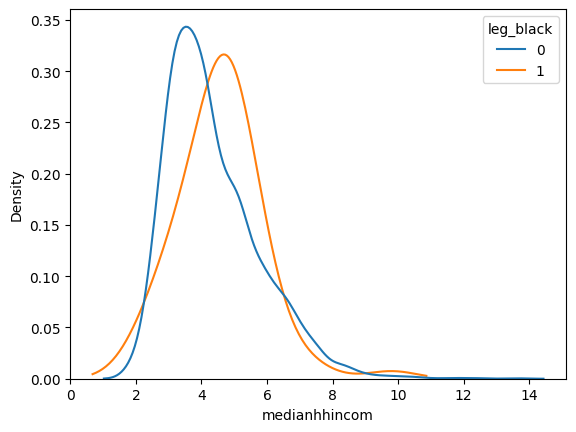

In [56]:
import seaborn as sns

# Overlaid treatment/control density in raw data
fig1 = sns.kdeplot(data = br, x = 'medianhhincom', hue = 'leg_black', common_norm = False)
fig1.plot()

# Start the new plot
fig1.get_figure().clf()

# Add weights from any weighting method to check post-matching density,
# here we have the ipw variable from our propensity score matching in previous code blocks (make sure you run those first!)

fig2 = sns.kdeplot(data = br, x = 'medianhhincom', hue = 'leg_black', common_norm = False, weights = 'ipw')
fig2.plot()

# Review Fixed Effect
- Estimating regressions with individual intercepts allows for controlling for individual-specific effects.
- Two standard methods are commonly used for this purpose, both of which are simple and familiar

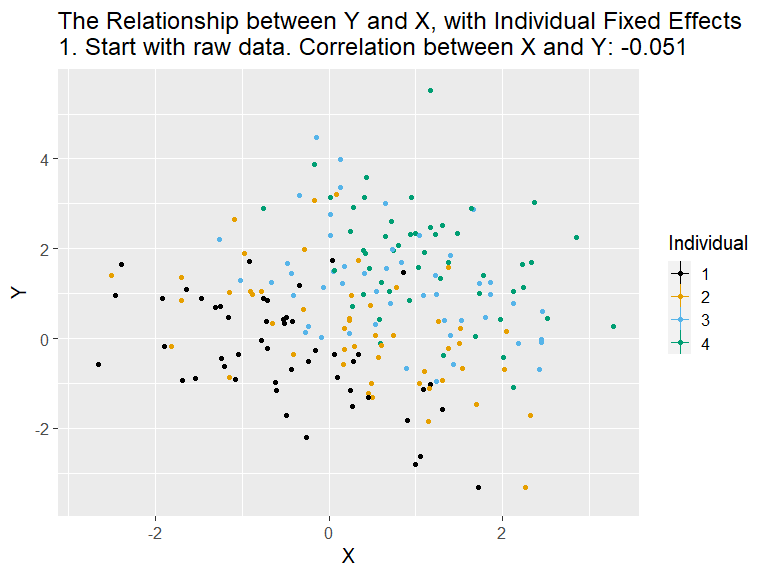

# GDP per capita on Life Expectancy

In [58]:
# Install library dulu (kalau belum)
!pip install causalgraphicalmodels graphviz

# Patch bug 'Iterable' biar kompatibel dengan Python 3.10+
!sed -i 's/from collections import Iterable/from collections.abc import Iterable/' /usr/local/lib/python3.*/dist-packages/causalgraphicalmodels/cgm.py


In [59]:
from causalgraphicalmodels import CausalGraphicalModel

### Load Data

This dataset records the changes in life expectancy and GDP per capita across multiple countries over time.

In [60]:
from causaldata import gapminder
gm = gapminder.load_pandas().data
gm

,country,continent,year,lifeExp,pop,gdpPercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106
...,...,...,...,...,...,...
1699,Zimbabwe,Africa,1987,62.351,9216418,706.157306
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623


In [62]:
# Put GDP per capita in log format since it's very skewed
gm['logGDPpercap'] = gm['gdpPercap'].apply('log')

In [63]:
# Analyze the relationship between log GDP and Life Expectancy

# create object model
model = sm.ols(formula = 'lifeExp ~ logGDPpercap', data = gm)

# fit the model

result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeExp   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     3192.
Date:                Fri, 18 Jul 2025   Prob (F-statistic):               0.00
Time:                        22:48:42   Log-Likelihood:                -5877.2
No. Observations:                1704   AIC:                         1.176e+04
Df Residuals:                    1702   BIC:                         1.177e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -9.1009      1.228     -7.413      0.000     -11.509      -6.693
logGDPpercap     8.4051      0.149     56.500      0.000       8.113       8.697
==============================================================================
Omnibus:                      148.382   Durbin-Watson:                   0.398
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.732
Skew:                          -0.698   Prob(JB):                     2.12e-45
Kurtosis:                       3.973   Cond. No.                         55.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

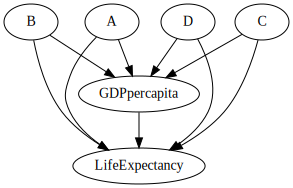

In [64]:
# Create causal diagram
gapminder_diagram = CausalGraphicalModel(nodes=["GDPpercapita", "LifeExpectancy", "A", "B","C","D"],
                                       edges=[("A", "GDPpercapita"),
                                              ("A", "LifeExpectancy"),
                                              ("B", "GDPpercapita"),
                                              ("B", "LifeExpectancy"),
                                              ("C", "GDPpercapita"),
                                              ("C", "LifeExpectancy"),
                                              ("D", "GDPpercapita"),
                                              ("D", "LifeExpectancy"),
                                              ("GDPpercapita", "LifeExpectancy")])

# Draw return a graphviz object
gapminder_diagram.draw()

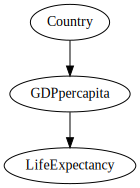

In [65]:
# Create causal diagram
lalonde_diagram = CausalGraphicalModel(nodes=["GDPpercapita", "LifeExpectancy", "Country"],
                                       edges=[("Country", "GDPpercapita"),
                                              ("Country", "LifeACExpectancy"),
                                              ("GDPpercapita", "LifeExpectancy")])

# Draw return a graphviz object
lalonde_diagram.draw()


- In doing so, we can still identify the effect even if some back doors include unmeasurable variables.
- This approach allows us to compare countries to themselves at different time periods, creating a robust apples-to-apples comparison, which is an effective way to conduct the analysis.

By adopting the Fixed Effects approach, we are disregarding any differences between countries to avoid potential backdoor influences. Instead, we solely focus on differences within individual countries. The Fixed Effects method is occasionally known as the "within" estimator.

## Absorbing Fixed Effect

- Perform calculations by group of country
- Transform each value of log gdp and life expectancy as the subtraction each variable's within-group mean to get within variation

In [66]:
groupby_country = gm.groupby('country')

gm[['logGDPpercap_within','lifeExp_within']] = groupby_country[['logGDPpercap','lifeExp']].transform(lambda x: x - np.mean(x))
gm

,country,continent,year,lifeExp,pop,gdpPercap,logGDPpercap,logGDPpercap_within,lifeExp_within
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,6.658583,-0.020972,-8.677833
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,6.710344,0.030789,-7.146833
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,6.748878,0.069323,-5.481833
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,6.728864,0.049310,-3.458833
4,Afghanistan,Asia,1972,36.088,13079460,739.981106,6.606625,-0.072930,-1.390833
...,...,...,...,...,...,...,...,...,...
1699,Zimbabwe,Africa,1987,62.351,9216418,706.157306,6.559838,0.126781,9.687833
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786,6.541637,0.108580,7.713833
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960,6.675129,0.242073,-5.854167
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623,6.510316,0.077259,-12.674167


In [67]:
# create object model
model1 = sm.ols(formula = 'lifeExp_within ~ logGDPpercap_within', data = gm)

# fit the model

result1 = model1.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lifeExp_within   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     1183.
Date:                Fri, 18 Jul 2025   Prob (F-statistic):          2.51e-197
Time:                        22:48:51   Log-Likelihood:                -5180.8
No. Observations:                1704   AIC:                         1.037e+04
Df Residuals:                    1702   BIC:                         1.038e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            7.216e-16      0.123   5.88e-15      1.000      -0.241       0.241
logGDPpercap_within     9.7690      0.284     34.400      0.000       9.212      10.326
==============================================================================
Omnibus:                       23.105   Durbin-Watson:                   0.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.240
Skew:                          -0.143   Prob(JB):                     6.05e-08
Kurtosis:                       3.622   Cond. No.                         2.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation**

- A slope coefficient of 9.769 means that, within the same value of country, on average  a one-unit increase in log GDP per capita leads to an expected increase of 9.769 years in life expectancy.
- The R-squared values represents the within-variation R-squared, measuring the variation in residuals relative to the within variation of the dependent variable.

## Including Binary Control Variables


In [68]:
gm = gm.reset_index()

In [69]:
# create object model
model2 = sm.ols(formula = 'lifeExp ~ logGDPpercap + C(country)', data = gm)

# fit the model
m2 = model2.fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeExp   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     60.59
Date:                Fri, 18 Jul 2025   Prob (F-statistic):               0.00
Time:                        22:48:55   Log-Likelihood:                -5180.8
No. Observations:                1704   AIC:                         1.065e+04
Df Residuals:                    1561   BIC:                         1.143e+04
Df Model:                         142                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                -27.7735      2.501    -11.107      0.000     -32.678     -22.869
C(country)[T.Albania]                     17.7826      2.195      8.101      0.000      13.477      22.088
C(country)[T.Algeria]                      5.2411      2.214      2.367      0.018       0.897       9.585
C(country)[T.Angola]                     -13.9071      2.202     -6.316      0.000     -18.226      -9.588
C(country)[T.Argentina]                    8.1322      2.273      3.578      0.000       3.674      12.590
C(country)[T.Australia]                    6.4003      2.352      2.721      0.007       1.787      11.014
C(country)[T.Austria]                      5.1559      2.348      2.196      0.028       0.550       9.762
C(country)[T.Bahrain]                     -1.9682      2.344     -0.840      0.401      -6.566       2.629
C(country)[T.Bangladesh]                  12.4011      2.158      5.745      0.000       8.167      16.635
C(country)[T.Belgium]                      5.6169      2.349      2.391      0.017       1.009      10.225
C(country)[T.Benin]                        7.7450      2.161      3.584      0.000       3.506      11.984
C(country)[T.Bolivia]                      2.3380      2.193      1.066      0.286      -1.963       6.639
C(country)[T.Bosnia and Herzegovina]      17.3528      2.194      7.911      0.000      13.050      21.655
C(country)[T.Botswana]                     3.1522      2.200      1.433      0.152      -1.162       7.467
C(country)[T.Brazil]                       6.3181      2.230      2.833      0.005       1.944      10.692
C(country)[T.Bulgaria]                    12.6702      2.239      5.659      0.000       8.279      17.062
C(country)[T.Burkina Faso]                 6.8580      2.158      3.177      0.002       2.624      11.092
C(country)[T.Burundi]                     12.6464      2.164      5.843      0.000       8.401      16.892
C(country)[T.Cambodia]                    12.9167      2.160      5.981      0.000       8.680      17.153
C(country)[T.Cameroon]                     3.0620      2.171      1.411      0.159      -1.196       7.320
C(country)[T.Canada]                       5.4647      2.366      2.309      0.021       0.823      10.106
C(country)[T.Central African Republic]     4.7576      2.159      2.204      0.028       0.523       8.992
C(country)[T.Chad]                         5.7370      2.161      2.655      0.008       1.498       9.976
C(country)[T.Chile]                        9.9150      2.242      4.421      0.000       5.516      14.314
C(country)[T.China]                       21.2712      2.160      9.846      0.000      17.034      25.509
C(country)[T.Colombia]                    10.9197      2.209      4.943      0.000     

**Interpretation**

- A slope coefficient of 9.769 means that, within the same value of country, on average  a one-unit increase in log GDP per capita leads to an expected increase of 9.769 years in life expectancy.
- The R-squared from the model showsthe overall R-squared, considering the variation in residuals relative to all the variation in the dependent variable.
- The fixed effects coefficients are on the country binary variables we got in the this regression
- They are the intercepts in country-specific fitted lines. (e.g., India's 13.971 and Brazil's 6.318)
  - The fixed effects estimates show the predicted differences in the dependent variable between countries, controlling for GDP per capita.
  - India's intercept is 7.653 higher than Brazil's, suggesting a higher life expectancy for India relative to Brazil at the same level of GDP per capita.


**Note**

- This fixed effect estimation we've done relies on the premise that all the back door variables can be represented by country-specific characteristics.
- In other words, these back doors should be governed by factors that remain constant within each country over time.
- However, if a back door variable fluctuates within a country over time, the Fixed Effects approach may not be effective.
- For instance, war is not a fixed characteristic within a country, as a country can experience war at some points in time and be at peace at others.
- In such cases, we can still address this by additionally controlling for variables like war, enabling us to overcome potential confounding factors and obtain reliable results.

## Two Way Fixed Effect

- The regression model for two-way fixed effects includes both individual and time period fixed effects.
- It allows for capturing variation within individuals and within time periods simultaneously.

- Suppose that GDP is increasing with time.
- If the Life expectancy and GDP proportion also changes with time, we would have time as a confounder.
- Since inflation also affect GDP through time, some of the positive association we see between GDP and Life Expectancy would be simply because both are increasing with time.
- To correct for that, we can add a dummy variable for each time period. In linear models, this is as simple as adding TimeEffects to our formula and setting the cluster_time to true.

In [70]:
# Set our individual and time (index) for our data
gm = gm.set_index(['country','year'])

In [71]:
gm

index continent  lifeExp       pop   gdpPercap  \
country     year                                                   
Afghanistan 1952      0      Asia   28.801   8425333  779.445314   
            1957      1      Asia   30.332   9240934  820.853030   
            1962      2      Asia   31.997  10267083  853.100710   
            1967      3      Asia   34.020  11537966  836.197138   
            1972      4      Asia   36.088  13079460  739.981106   
...                 ...       ...      ...       ...         ...   
Zimbabwe    1987   1699    Africa   62.351   9216418  706.157306   
            1992   1700    Africa   60.377  10704340  693.420786   
            1997   1701    Africa   46.809  11404948  792.449960   
            2002   1702    Africa   39.989  11926563  672.038623   
            2007   1703    Africa   43.487  12311143  469.709298   

                  logGDPpercap  logGDPpercap_within  lifeExp_within  
country     year                                                     
Afghanistan 1952      6.658583            -0.020972       -8.677833  
            1957      6.710344             0.030789       -7.146833  
            1962      6.748878             0.069323       -5.481833  
            1967      6.728864             0.049310       -3.458833  
            1972      6.606625            -0.072930       -1.390833  
...                        ...                  ...             ...  
Zimbabwe    1987      6.559838             0.126781        9.687833  
            1992      6.541637             0.108580        7.713833  
            1997      6.675129             0.242073       -5.854167  
            2002      6.510316             0.077259      -12.674167  
            2007      6.152114            -0.280943       -9.176167  

[1704 rows x 8 columns]

In [72]:
# create model object
model = lm.PanelOLS.from_formula('lifeExp ~ logGDPpercap + EntityEffects + TimeEffects', data = gm)

# fit the model
twfe = model.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)

# show the summary of the model
print(twfe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                lifeExp   R-squared:                        0.0186
Estimator:                   PanelOLS   R-squared (Between):              0.3542
No. Observations:                1704   R-squared (Within):               0.1127
Date:                Fri, Jul 18 2025   R-squared (Overall):              0.3514
Time:                        22:49:02   Log-likelihood                   -4435.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      29.366
Entities:                         142   P-value                           0.0000
Avg Obs:                       12.000   Distribution:                  F(1,1550)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             5.0306
                            

- In the updated model, the impact of GDP on Life Expectancy decreased notably from 9.8 to 1.4.

Reference:
- Causal Inference for The Brave and True By Matheus Facure Alves
- The Effect by Nick Huntington-Klein
- Broockman, David E. 2013. “Black Politicians Are More Intrinsically Motivated to Advance Blacks’ Interests: A Field Experiment Manipulating Political Incentives.” American Journal of Political Science 57 (3): 521–36.
- Gapminder Institute. 2020. “Gapminder.”